<a href="https://colab.research.google.com/github/mirpouya/Transformer_EDU/blob/main/Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, re
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torchtext

print(torch.__version__)

2.0.1+cu118


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


the first block in the model is "Input Embedding"

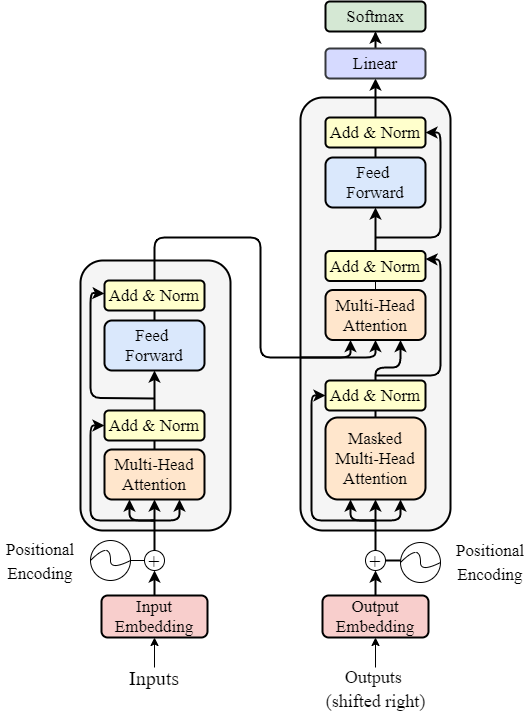

## <b> 1. Embedding </b> ##

In [3]:
class Embedding(nn.Module):

  def __init__(self, vocab_size, embed_dim):

    super().__init__()
    self.embed = nn.Embedding(vocab_size, embed_dim)

  def forward(self, x):
    embeddings = self.embed(x)
    return embeddings

## <b> 2. Positional Encoding </b> ##

In [4]:
class PositionalEncoding(nn.Module):
  def __init__(self, max_len, embed_dim):
    """
    Args
    max_len: maximum lenght of sentence
    embed_dim: dimansion of embedding features
    """

    super().__init__()

    # in this class a matrix with the same size of input is added
    # this matrix contains positional information of words

    self.positional_encoding = torch.zeros(max_len, embed_dim, device=device)
    # we do not need backpropagation to update any weight here
    self.positional_encoding.requires_grad = False

    # pos: position of a word in the sentence
    pos = torch.arange(0, max_len, device=device)
    # 1D -> 2D
    pos = pos.float().unsqueeze(dim=1)

    _2i = torch.arange(0, embed_dim, step = 2, device = device).float()

    # calculating positional encodings
    # even positions
    self.positional_encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / embed_dim) ))
    self.positiona_encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / embed_dim) ))

  def forward(self, x):
    pass

## <b> 3. Multi-Head Attention </b>

In [5]:
class MultiHeadAttention(nn.Module):

  def __init__(self, embed_dim = 512, n_heads = 8):

    super().__init__()

    self.embed_dim = embed_dim
    self.n_heads = n_heads
    self.single_head_dim = torch.int(self.embed_dim / self.n_heads)

    # key, query, value weight matrices

    self.w_k = nn.Linear(self.singe_head_dim, self.single_head_dim, bias = False)
    self.w_q = nn.Linear(self.single_head_dim, self.single_head_dim, bias = False)
    self.w_v = nn.Linear(self.single_head_dim, self.single_head_dim, bias = False)

    self.w_o = nn.Linear(self.single_head_dim * self.n_heads, self.embed_dim)


  def forward(self, key, query, value, mask = None):

    batch_size = key.size(0)
    seq_length = key.size(1)

    # resizing with Tensor.view(...)
    """
    suppose we have batch of 32 elements, with sequence of 10 words, embedding dimension of 512, therefore after embedding and positional encoding our
    input to the attention block would be (32, 10, 512).
    Since there are some heads, e.g 8, we want to resize the input to (32, 10, 8 * 64)
    """
    key = key.view(batch_size, seq_length, self.n_heads, self.single_head_dim)
    query = query.view(batch_size, seq_length, self.n_heads, self.single_head_dim)
    value = value.view(batch_size, seq_length, self.n_heads, self.single_head_dim)

    # feeding key, query, value into their corresponding weight matrices
    q = self.w_q(query)
    v = self.w_v(query)
    k = self.w_k(query)

    """
    Assume our q, v, k (feeded query, value, key) have the (32, 10, 8, 64) size
    for the computation, and multiplication convenience we will transpose them to (32, 8, 10, 64)
    Now when we multiply query matrix with the transpose of key matrix we will have
    (32, 8, 10, 64) * (32, 8, 64, 10) = (32, 8, 10, 10)
    """
    q = q.transpose(1,2)
    v = v.transpose(1,2)
    k = k.transpose(1,2)

    # compute attention
    # Attention(Q, K, V) = softmax[(Q * K.T)/sqrt(d_k)]
    # in fact q -> (32, 8, 10, 64)  ,    k -> k_adjust

    k_adjust = k.transpose(-1, -2)   # this is equal to k_adjust = k.tanspose(3, 4)

    q_k_product = torch.matmul(q, k_adjust)

    # masking if required
    if (mask is not None) and (torch.is_tensor(mask)):
      q_k_product = q_k_product.masked_fill(mask == 0, float("-1e20"))

    if not torch.is_tensor(mask):
      raise Exception("Invalid mask!")

    # devide q_k_product by sqrt(d_k)
    q_k_product = q_k_product / math.sqrt(self.single_head_dim)

    # applying softmax
    # in the "https://www.kaggle.com/code/arunmohan003/transformer-from-scratch-using-pytorch" softmax is applied to the last dimension
    soft_q_k_product = F.softmax(soft_q_k_product)

    # multiplying with V

    attention = torch.matmul(soft_q_k_product, v)  # (32, 8, 10, 10) * (32, 8, 10, 64) = (32, 8, 10, 64)

    # concatenate heads -> (32, 8, 10, 64) -> (32, 10, 8 * 64) = (32, 10, 512)
    concat_heads_attention = attention.transpose(batch_size, seq_length, self.n_heads * self.single_head_dim)

    # multiplying by its weights
    output_attention = self.w_o(concat_heads_attention)

    return output_attention

## <b> 4. Encoder - Transformer's block </b>

![Transformer-encoder-structure.ppm](data:application/octet-stream;base64,iVBORw0KGgoAAAANSUhEUgAAAUcAAAJTCAMAAACsOCRJAAAABGdBTUEAALGPC/xhBQAAAAFzUkdCAK7OHOkAAAMAUExURfPz9SAgIH5+fnh4ev3h4f/ju/P1wf///wAAAMPp90ZISMHBw8/Pz+Hj47+/vy4wMn5wcIGBgYGBg+PNr5GRk6mrq8PDw9nZ2yAgHjAwLDAwMIGDbKG7x0A8PA8PDxcXFz5AQNLT0xMTE35wXAQEBe/v71RUVCIiIp2dnQsLC+Hh4TIyMjAwLnBwcjIxLCgnJggICNzc3RobGqWlpdnbsysrKe3t7T4+Pvb29ujQ0o+Pj+Xm5tnZ2c66n5WVlmB0evn5+aurq+LLzcbGxmlrWPz8/N/LzUJAPuPLrTg3OPHx8i0vL1FQUMnKysGusB0dHW5jVpCnsujo6F5eXsKvlmFaTlNPR0RDQ0tLTD08NCQlJFBcYOPk5G1tbuvr60pHRe/wv97Iq73g7s7Qq0lHPjc+QszNzWZlZtbX17q6u9fZsFhYWfTa21RLQENJTdK+wDk7O4iJceTmuDg2Mpqaml5gUquXfMu5u6aVgV5bXNrGxunrvCwrLKutkXh6YIiIid/f39zes67M2KjF0DAyNXV1dbOjj6mWmJWHiYaGhmJgYUxKRdHR0u3V1sbHo6eoqDM0Mz4/Oq+vr5OUetS/oo2PdbKys/Pz81dTS7fZ5mJiUyAiInZsXvfduISGbjIyMJWHc+jQsMHm9VpbTXBvZOvtvaKkhkxVWZ23wa+eh7i6mIR5e7LT36OTlYyJirupqrqokPzgunuQmW9tW3R0ZYWcpldkamZsbvLYtdrFp3aLk7KjpExOT5+fn3KGjsHBwSgqKHx8fKOjo+/Ws/jg4Xl4cCwxNGBZVba2trGyksO/n5yYfVNKSkNFPLK0lYF9amx9hMu3uYt9a2d2fb2+vnp1ZXJyct/htX5zaqqsjG5kZYODhJ6fhcW0tbWjjJmQeKO/ynVrZsaymVpfYX90cbGxsd7IyXdtb3p6e3BwcJqNjaGhobi6p8vNqCAhHp6Qj15gUJWstpavumpsXKKTk3FzZT5FR7Gho35+ga+xj9/f4ezTsYp9f4ODaklKQZ+7x1QToQ8AACAASURBVHgB7b0LfFTVtT8OcTKzg4jwuwYVP87oMCQErIRUCAICCrSGhxEQgSgYQeVtUSiKRESUq1DFyMMB34Yftr7QtGLVUgWdX6sWrVorvq62/qut+rG3rX3cqlf/37XW3uecmTmTTJKZZE6cncnea6299jp7fWftx3nMTJdAp03HKVXXbs51abcjtfuB8jhmBvI8jnkcXRDoN/aZq3p1ROqqVCijxz3ilgUu/okoy/PjucOrVGdK1fMXjnfFMps4Dl2xrDNhqH0JbhzrgmT2cBx/SDkfOTRz9qjijkgTlSrN6HHfXqzjok8yklnDcdhMRnHvc12iHZSwXh+e6UMv2F/Nbq1IDMls4fhtzPJKdVsQ7TAYo9nAMRrt9wkjuXFOPJJZwnEVoThz84RMx0NL7GUHx2h0REEIzoXXxgGZHRxH4UDBb7fE6SzoZgvHaPSwSfBvRvZxnBrEcYZnAZoWmcwejtF+M+BgLyeQ2YjHc0uVKhveoWOaAM8ijtG1lQBygwPIbODYB8f4pOPWFxO02cQxOnUgnDzVBjILOL6GI6wyznRgmVUco90jOO0cYwGZBRxLsMYc1oH4mUNnF8foYoTLc1nEcW25Uq8bXzqyzDKOvYHjjCziSO/Tgo7Ezxw7yzhG98LRAQbIjI/rMQjHZcaVDi2zjeMHwHF/1nC8CdavagN+U3sfmqFUr9S+DJk6tPfU5P3H0DAOkDUcaVgf2Uocu0wdfhzCORdT+XHDpyZ6tREdNafZGR/XOJWpTzxguvxavriRizBSn6rXJvhxKoTDdUBmGscobE9KOF7aLF/doC7nZkrYFHeZrFRkfpZwXAsIZqcNXLziQmxt1VGfHZOD6bM/o2uRhfH9PQyyGVnC8QbYPiT+cGlzdPI/6FJ/TqZLB6FzxyW4ApFZaDI9rru3HscRaKpeyEkU0akXqHcj4oGEpGuW4rH1OHa5iLpFMNbm4J/fT2vgRR7AMXooOnoCIExKq++9N1G66d7VDrX746L46nvfmeeo9PtX33u/xW/6t0W2iKj1n4DuHeoVHPuQcwSa8//fSm1KcHqcWuSQXPAXB/MOXUT+Bwu0kZNU8CSjMO5EQ7W09BSOJ8QjKEA8Oqj8GABr//lrx6mTLN5fCxxNpX9e+V9W79oS2QQJEhs4SakXtYJ/3F2WqmmSTglTdFU1V+Px81H97JFC43qiW5Sc+M72WQnyhHj8vlUNhK8G8+KtyBhJlCepo9QWrdHaeMzxcb04tPgmA6XMj+R9/OuFitWfljmGMcFD8SiJuBf/ohkUOxXNnDt3skQMLVLHzCp7gQS1FI+tSHSQnB7XxyMGQ7Nv4KBMFY9fAaW7xgED+pv3l7CqunMXxSPYLd9VZds3+S+geJR6/0vqTaws1cjIeU4nqUsOVr8oAo7HWv9JO3HcR1dTm4HbardVDfLP2+K/coYK/+Uk/0m3BlXVFm1PW4Wd3MJx6pHxaRKAVGr+8bic4h6P/kXqXr//0ZCsz/eXh8et2Rm+VeLxs8jyNY8uV1teBI4WajdjLrz16F2EIGT0Ao4CL0Q8P/r/HQ79ZM2twRqK8j7bXlRfbfNfefMlaueas1XFvNCsNT8pVe+QASvBTO7Mj58fUXI4w+aSzfxggms81vp/qw76/f/Wfi0fRK5fXfMDWq83lV9COG0pP9GaH8EuCh5TH74fWqAlEY7+ryowE2Bc03q9qbyGpoUXymvw7tz1VSntBq4cFPoUxRb151+jWL08cUbOlXic88mkMhf8bFHpetC8XgMA6+U/GKZgW10xpBayd0LAFOX9CvPjriE8Cdb631ESj6hA2jRIHY2lhhlkeC0iHDcFl9MpJ82Pu4YcxbNr7fPlv/L7B1Yzc6Ui7P21XfdRy9r7Q2hp/tjYRHSv49frwctsxFyp6lF0n3Ei+RKX/p/iTfWvI/dCfIEsH35/FeLxBXWl1qwx8QjHP1OP/lZt4wqGEtRJ6k7kW9RXEFA8buLVm2q3Q3SX2LzyKPCQ3QwWxacKbFzKifnxtQoN3sRu8WmIyLt90M99ftxVIQvEIvUV/NuHMUf+Y1U+CWEIhJmb9X0qmdwSwQpxtvrUv6kbakVM8YjKr9RLEo+/QrWkSxD/d4nNK48W0c3/4NKBI5vOiX1Pv/V0RUz12XBowol+dAAeOYos288Ltuv8+JLGHwVwoQHK4NB6vYbmSOZonZF0MIiF2r96+4mXviO1JOb50e+/dNaJqzket9CMy+hcuc/vrz+Gm16JQIXMDxyp+FSxAo1snXIgHt8mMIK7XZ5UKVDlsz/XW3HCUc5nuPfsh/8vy7Ub2AT6/YN+rf2ieLzXGY8kR7Nf1YnCzcu/CllWGEfUXx3+jOdHRzwCvIF3chPCkUzc/CgXjngUizmwXg/GDSFVcQO2NompX/3+wZbMNR5rOALJwRexgs7YyajW6vnx3+K635of/cdgGSG/sRB9xqqUAUeIkP6hrjTzI8PuPxuTxl0Uj7V+4MhKN/+DC8ZRWnHTXBjXMwGj+sDCy0Ec5nzuwhmP5BO9NkWuRsn+vBO81H9JjTDzaL1eHZIhiAUH41oavBTexW7v2kdrizYi4xrM1cGKnQi71eGj2aJ/URkwRDxSknjEuEY8olbHIx1OrHT8vucqoJjOw5Bu8fjVV+wkZasr7vRf+uedNLVd+uJ3afZ7hydD//PVQ6z5cXXF9oPw+9KdoZ3Waq7Xa7Lx7zKaOfzvlJ99KbTmDQrBCsUjGGtc/19SZBwhdaSOnh8/pzupoxxBmIpMiEd4UfsC7WCIoOxWnNPo85md7yAea/2fqeVrflKlLhln1uta/5tK3brmL+Gaq/2/DpMKvfR6Dcq/JYJ4xCB2nM/Y8UgKFI/Uah7ve0hCHL06Gse3AeNAcy0iFYYkd4nHN9dgR23S/WsW1fo/3RlWs7bt2rSGNtW1OKUL7tzkf5MWaZ02QaH0Vora/31Hiy5dw1ts5rZt4eJqOb8mfLbczzDh/Jo4/6940vUfXEMMS7hBx59fDwSOaT3ibMUj+2W5oDntTYpClNhzWyNeaNmxtWzKOhq1tjTZlHAdHo9HAsaKdMKxywJohqzbheSjw08mhUdOhBQs4sw4zWV840ROmpKiprQB5jQttTazmjYdx8ePJ0ja7T7XZhxsZvzhU3F0zkOzvN15kOwbOcXJqrII0bb1iGLOgKQZMeSwlmRBLNFhWEvXS4ta//9F5yoSet6eOI7CwdYnHD8FOxuqahv3n53XnsR7ZtUYB524O1rYqDAwzhrByTKrCSq4kUPVJrdR3xIfcICo3eKRdj1pPn92WDV1NtgV6Tb86VSty6NMIh5016O4gqVaxW7UtZpoNDWtoQGSGuGPGh/FvLFJonhVqykboXtnqtqceZk4gKzdcOyFgx1hDtxMSXNADqfixO6jrzmJY3QFv++5CWVwRSKM9ExYbuIYPXI2LgDlYgrNPjIJxhzGMRqdcFimEq4cT8yUrcNcrlVFcxrH5He9tZLjsvC54fi+5O64ju9n27g8jm3Dz7T+ZuOYnx/5icrumDPinsdtyf4x2mXw+vx6nQEcVwT5hlgubnyUd/aPXYbnJIBWp5JOb1GTi/vwI/mBi9DhOZh4tilL/NhkjuLI13ueLMrJ9CRFZUde72nBOkPXH3/aUJSbfz9F5zry+mP6OC5AT8NzczIai4oa5obRvQ68Hp4+jnR/5vDcDMYGvLu/QPc68HmzluH4ixwNR0w2h3sJx8NbNTt+PdpKDzYf0FN+3IqDFHkLx1/QCKJ/SmmXT6oLL9ZpXfPtHruwBaa5I2zTY/HI6ElQkbv012z5pLrG9rdZfeAInTRNaz008NT8SONav5ovSZFBduAoAqkRU7YdrU/xqEkq2EhzJbS8Fo/aNw5Edk98TMEzCoyj1oXeg1P2/G2u1p97zZ49mDMJroaiB/fs+bqhQeKRBU2aZg1kUnorHjE/ktOSNVdqzYYi4CiIUNOi32BhVUE+L2rYwyd0F+4g1R2PUcUvdnA8WkewCLYGNffSg/EonhCg5FLq0gRKUYMe16L6ZOTlB4vW/VO9jKZT1LV/K9rxZOiHoOdeqJ5saFh38bWPXciWRbvpQ7Aid8Fr67V0WvoPFMFKcim1CAXHo7ANDwZHc4v/Tz1YVHTxhXOJ+V0Z1qHfqKdIZW5dhWN+pFpp2EzpxXhkz6xwEYLxZXg1T0qmii8i0KBVvyt6LLiDxTtue6phXRBYEkzn/LBhR/hiblG0rgzxaNo6LDrsWYaZEF2PzY9WzylSKJHPJndQAoUW6HHNXPiHVCCd88OiJ6/l5phAgw2/U1OIAXAX075HzJJeIpXMk8SL8Sj95qhiD5J5SIyQNAhHUW+Yy2HJ2YVFvLCIYMcUxKokmh+plf5LpJJ5knhs/yjrtSNcLJcFA/aIQRDnGAuaH3V10Q71C3OO+OOic24z9Ogdeyyszf6RTbMZTYlxMHG8HMKD8cheWNFiME0QsFj81fserVC210BaVPTytTb9tfqbZn5o1mtGCDb4pQ2SyXieJCTy1PnML6jHdkAIh5xdoxpHPWlyjSMeG4r+GeIteEPRhY81fB3cISq/GTR3hzpHkN4RpnEtjckgJeKcuZOXCu/FoxUYgpHk2m/xHrmpYycd82NR0Y/VHsKk6EcoG8K0iYT2xN8UFV0YXscVLys+v7YsGlMO27Z9qpQKj8UjdZp7zj5r0vLF4rkWulLD+0dp2NDww9CeHdh7h7F1bHhKnXNN0dyvL67bUdSwrrpiCk4NXw79Ru97tDFjCqVGTI4vpu1ar51fizPkhXjCyLKPzBuhZth7XmesisfoHnjkp3Op6ik+L7xtHdE7zqGl+xcP7llmIUZt5M9xMBxQbEnJNDJvzY9xTjBItqPCIofIJO2lFon8mqdGP4kNOGvt+Ovo0V9rXBquGT36bw1IVCMvY4Z14+WGIxWy68V4RMep6w5XhBURQ0B1JGS1RG2RO3LRNEasNmJEDFkqILRp0de55+LReKHBMV7Z7nGFgCRAMC7kriEc+CRoWNAIQcYlWRVGJFhyNWeejUf0XpxjdBLds/DRtVQvrhtNwocRkCrmtE2uMMZNO9EVqdDUnG1S5q14ZM9tLwQJ4444ZYEgTlqOEm7ab1bkCk1ZFZqQI1DOtk2pbdlKrCfKXotH8cwGgXj+N5nmRQN1Vq2RiN9WM1YwMimNyOjY+NnAaruiAgVvxaPTIwGOPNP+CiG4CSAkMZ7CcVtXt+BqVjWaWqLrTWuxKcZQJcqWDlv2XDzCC+2IgYXxEVc1HOIi5brObiJgkBFN2aUlMI3YgGhaWtqoGAbDLxzWg/HIIDgc46gx7joxsFBlDct1y3mHxGAoTTQ4Yksak32tZOmQiI0h91w8CmDslnFenNHOW/WiokEXDFjkzDRtoNJNNDZGqrHSlXYheGrL3opHRkU8ES8tfCDUHgpBTJyj4CmxnqkUFanQzZ1tRJ3NmHa6uRgQe0R7Lx4ZPo2h8dlCTgR8oszXufm5KvGT0dCNRR/Oc5U0EmS0QCq4SdE/zyGYUMF1OueCrUml1/aPDl/ivBAvpbbonApznftJ+MsIWMoaANK3qggKEdi5Tf2TL0zqdnQEq6VpxYf12vwoiEguULBr5J5x8RzHdW7xNc5jUSSRNDLA2KwY0nx8PDJmuqXuhGh7cH50uC8+wDknOISjFTRxuIuctbUCKxIujio2ZvHA0QGYNmwdzpjx3HqtOy5xITljQM7rOjsepX7K6NF0M7Ch6JrRc4vWPbWOpFJj8oaiHXtGj8Z1XAiu+XGRKDX8aPTLuEEm8Whso6m0pqasr0tvxaM4ziiwE4IcpPIiH3Frmu5Lyx8qfncbLTkX09NQU9SDWIP20K0YpAtxawtac8P/xG2GECnV0P3ZKRfOhdKPGvCgCrXbYeKR29hmYYAldBxK3pwfdefFBfEItMbOjkdInor88Ouior9NDP+Nnud57OK/zi26GI/rIwIjwZcJgD24U7On7Dc7ioq+/kUIaE+59kIoNay77cLfNTT87pzbrjXrNZtHAz6QdUwW4MDeikdyQvDSXmnoWC6oNhSdU63Xa9zKukaCr2FuDW4UTlEXU/O/IdqKGqaU/ZifnPhnNTYt8kzPj9SPIS9/jJQuDD/IRl9WwFEfVR/ZHIwBpQ5Q8mg8Gl/gAbsjvopT1v4Rj+w8pRBi5OkejOIpeKQMzNwQHolq+M3FD4Ygn1uOdeRiEuCBqQgeosLgB7OO4COjc8toncFLH4ZKczChuc5j8chOcMeNLyRx/oNxjutzjtN+71BPASJ5+OSH9JDPxU8W1eC5SDwAIHdkIPqNGo14vI1a/BXP+4jdXxCg5giaACsvFFSF5NF4FMckJ6fELfGKcCSKanG7n8uihsN/AxzXsfjrioaGubc9WHTO6Iail/eR2tcvX3zh3osfA45FU+hhg4aX9bOneHKA45GNsClSF2B1TlKvnc843WGHKBPPLK/seIR/vGth/ye+jPmR9zxFRTVfF/0IYD9Z09BwIQ3pc9RoWqqv4Xjkk8mnELpi90LHOsPHIGtyWORCohNei0fxTlyM80YYgtXEI+iic+TpCNyexnOiFI/s+Q9HNzyG1eQa9buGEEQ/UvKYM+GIeCRspqi/wiBRGNcMlrFPpYUfM1TtufnRdgcUO0iF9k0EwNHy78fqR+x10csgZFxD/8e37bgNz6c01Pz0b4g+PLjCtvAgEM2PFI8NO4IXY9oEsQ7rjCQHmvYBTRe8GI/iNHxk/9hb7Y5IeJ3REO8IVfD+ZYr6Jy3F6wiaoqIH1ct4rrmhaHQFIpMe+qHgK7qm2pofsZwrPr2Zuy8k8UgK3JYJsg7CCMF4cf/I/ScftDPijrgFWsa1dntKeTVW3h+X4+ETHteoR6s6VUf1X+PsBuyDKvSjoh1/7TqlvG4dxyOU5u4L/7Wh4a+33XaOnP1YB9MEH507IEf32vzI0DFk0n+Tixyc2fdoxaIf1fD5HT2JoudHUKMVr+MNIXrcHuOcPvWrRjeMxkad5keyos8LH3wM49rYAkEvrpfS0B6LR+48e0WUwQ60rtBecp1xsejrPXvWEUNJN6OWjlZFc/+2ZwoQpSlRNEA2XLNnyg5uxJluQrQclwtNem+9JjctZ4UwrIAgODDNuvCUN9oGBxayEQeSoqItiwVqxg01XqaJIGfhJ6h6cf9oHJGwcMIjEGkXBQ0HagwEeGnBWgk6DhlhjCQKQkk7S2wbYpHX5kfLNXZUvLX9ZSS0/wKFeG9y0WTH7UZxiMCiNioUMcaqJrlCK1kiD67Xlh/GxziBdpt9dwDA2AlPuaEskuvBUdLVbJZZS2bqHQIReW7/yN02mfbBct8OHaNhQDHIEc8JBVHCSS1jyxlp2DUghWEpk4bXDBS8FY/Ub/EKlGFMadVYGlpiQBGWaq3WxhwhR4lsGZmYcYgsATcXTsu8E4/0c9KRdZYr7LJ4bXlq4aCR4GrbXc1qpBwGSEX+pCEpimm7MbdiucOMrbSOvuwq4QubIcnF7+XCFzaqfTvIH3RfHDTe2yDYQAgUxlNqZloZcIwd0dEKXMTXUL0cwXFUbUzbmrsPnVtmvlpSlzmKI31lu7r2r1/nYJpyLfUt8VdLIMrFeOxXSp3NycRfp9g18Wci0NVcxDH6Gp8F5ySQ6FT4tYRhnbvf1zx4Va6CqNQq+5fEDJ65Go/o3w3r43/fsE3cjDa1jmu8Xn7L1yAoZQ7jGN/RtnGfT2tb+2Zbf0NwfD0yslko2qTwzcBxRLna0CaYmm38zcCxWKluzULRJoVvBo6LlSpP/GbgNsGW1PgbgeMIOiHemOR7JgXfCBz5LDOY+APHmYQxd/fhmfSyCtGi1PBMmky09U2Ix28zjKp0aqLzGeS/CTjWC45qt8vPRWcKys6PY5eFGka1L1Ogudjp/DhGF6sgReRMpbq7AJAhUefH8ciq4Yd9C25GJ//07QyB5mKmvXHM6qLp4l80StsdxlFIV522C9sRxy70mzK92t7lVljQOLaiZbpN2hHHaH8cbH66HcuoXufCcTJwrMooPuka61w4jgCOZVk9O0uFa+fCMUp3pdP9weFUkLRK3slwvAk4hrN7/cod5k6GY7QSQA4c6u5rNqWdDcdDgaP6aTYRc7fd2XCMziYgP3F3NovSTofjHLoUWLb/sCxi5ma60+EYPZ6fN3H5YU839zMm63w4RnvLgzv1bx/ajutNJ8QxunZ2OU2SSF3bLQVxtIwFt6shcod/HTgQ6KLLTBVJv9tsOtCjmlBs72SOnp0S3rQ7jtGh/Qe1N4qdMR4REf0Wzp7JnwVsPzyzE4fGaofEozl4u5WdcZ1pN/AcB8rj6ACjDWQexzaA52iax9EBRhvIPI5tAM/RNI+jA4w2kHkc2wCeo2keRwcYbSDzOLYBPEfTPI4OMNpA5nFsA3iOpnkcHWC0gczj2AbwHE3zODrAaAOZx7EN4Dma5nF0gNEGMo9jG8BzNM3j6ACjDWQexzaA52iax9EBRhvIPI5tAM/RNI+jA4w2kDmC40gVGmM/ZaGUg7HFSVTK5ynaAEgrm+YMjmq2DVMeR5d3M63nAEZC6zkLyPbDccSRGUrz4UCGTB3p/oGLNHHcWBc+1wDZPjhOOHVVBTqXg6li1akTkiIS/Wz+OamR6pm1qqRdcRwhn+HPQRipS1VJQZkujoEVarIGsl3i8aMcRVB366PEgEwbx8AJpXqZFhwXmPAMRKdaZBzRlvX6c3ryM4dT8PMEINHXtMZ1IDBAdRMgBcfZ0yYIamP3mUCNQzEQaAuOtDCE793lz8G06156Mnt+q3EMDFcbGSk9risHjSC2OJICxrbgOJQefX4pB0HkLj2PzpVPjf+yC4jSjMdAYIbqTsiZ+bFyECJybEoY24Lj8ehWqNbv51ctilz689eG0L2ELy9sCY79Tqga78AxMLxywth6aztEEMelNoxr+tzXCbkajn7/CejeofEDuyU4Yop8HUiZeAwEZlenjsY2zY+EYx8ORwpJR5qn1NUOlshxapFD8uL3HczqcUp99alD4D9JHW2x42zSkqVBoENtxTFwhOrhxPEIpVKHY1vGtRWPhKI9pv3+bUrd6xBQ9Th1kiXx+y/4vsXU7loe/slPao7a5TCwSKktWsE/7kRbNW2KgZ7YxngM9FPVUTseh5aOrZwWN5TjmDaP6/hQZETP/myIM+DIK2c81hKOVtqinvf7V/95myXwIx5V2IQvcGx5ovek7fEY6K1mjDHj+rWuCM6NZvsTByEzLcPx3FscJ1tWPFKvHelgeNE7odW2gLyieLTTi3+x6Z1qF5id240EthapceEhl5IADe8yFS0t+7Q1HgOBUQrfesL7yP5ygqO3P8kwtnRcd6vef66Zu/X8KCjaw7L217P8tRXvAA+WLdq25vlLCUfm7l/zv/N4XEsl8mMUBP5Za8zUAOYkdeeb6rckQCAjHqnlvDVrthxkE1teqN310jYmX1izbRGIqy9Z89Jq1mIptcOrzfMj0OqGqweE42vmPJG3Py4wthRHfJtbxdv6NMGOR+q2lXZV3On3b58l/OpbERUqdL/E4yb+jNhXBy/4i6XtPxgGYi+E7XCtRTxe4h8XPsg6Eo+7fktfrB7eQqK7tr1Uofb5r7z56nqyfYz/11QcZSYCy3IG4hFrtuA4w9p+V252Q7HF6/UcQqJ8MX93luAob77Ve7//ebWJlpp5DO4/1D8O+hc9Wnorrde7akqfr619vuYurNc28tvCJ10ZGuc0cxJwPBjayVHF8+OuF9VvL/VfvTNyDI5T/2j52S/4/VfOqtk+z//p0erR217yr95SdqujC2y9tfE4ouRpG6qnS0r0ibYtc6Wamh9HbN4wu9tx8amU3nwVWdZr7ARHPKLj5m/X0UcDk0URwOCvnRd8kwr/nWGaH289mie91dvLvs9SaeK/K1zxK5ojSZHhpXj0/4pGNsY15sfaW8vvJbp2nLof8VjNzJUMqv9gUEJ5S43VA7ZR2+px7QpTs8KUOHb5fH3TlyHqdwNQ7MOdkQRnn4/cS6KzedrbiamSEFgdwvy4KLKNtf2XBglHneYtD/25mkY1K3KJeATzlfoVOIrHkyJav3bIOMQjTRm1/ivLsFVCWnYBN90UIUYnrmhtPDYLmatCShw/CdKU1ETa9ydUJp/PfBXaRd48r/6BvP5R7dlXiMcracBzOlHGNbk7L1Sz6NPwkF3+g5v0Ck3rNeKx9uoQTZEUj/+mMORYHbcc8fgoQ37lPrSGhZt/wiY/VVw4stbOj64wNStMgWP3Eo1i18PjE68UStWvv2WoHtfwhV8ySuepirOXnv3V0q9UGLgEseQwBLR/vFPOaaDM5zMo/bW1y3dih/RCxWcAfh4bghTrNTV7KYw5j+JxS8ScHr25DzjSJIn5ERWUbqb3q9ZPOEoPZHLIjXFdzJ9ij0wqTryC16+GIrTb07T3cc6P7BJlx4TXSLoV5zSMI+HlvxXxeInCJoWTvX98KcyiRcFtjyraujCUFI9E3hu5n+NxCxpL1Zt1fv9AgAyOcCQhcKQiPh5JkgPj+lCGsetCs1O0y1OVCs7WV1EIxz7oMDotL9D+WbS+UNoVQjRZ4/oHgIIXctbEuNZN/peWEbx+XRZ6EaUkWq853dz1IMXjv4Enq/nHLa/133UnK8bFI+NotZfGOYDjcRR0s92+8XdvePaRBtXEeKQBdbCMXOb02SCcpmBNIJhoncG0t01qHOvMr4Zo0Z/VO6BI18yPYN9U3/8JcFykgDvV1g7Be+OIR1K+GVMwCo5HM7BZ0vHzI992cf2pg3Nvcnzvh+DI05H4D1d/O0RI5IvKX/J/yvsev//OEObGWt731PpXb+f1mhUXlQt8b0bCFWbUY36k9ZqA+0yFaCX7PvY9pC77Hmt+ZKWb/8FF3LhmSYfH400UjW/HX0k2MegsE+MRrh4Mr2EAOJt1M5YJs7xQLQAAIABJREFU3of/I7QN8ehfXS378JrvS3yR1q1qJyL1t+qSg6VfgSW09HpNtP9FhXisxT78/13qP2mnOgYyxCNpybiu5XiEQNYZsiip49eZfnWAsVviT1s5AdS0mR/ZLYYApzHPM8FwHKM+9a/eSW9KxUvv8Fr9At/s/sHV4+S6GTU8eDYp0M5yXhAZJ2t+9PuvDgFHvAOPkpY+L9TxSIGKlBCPMrSpoqPj8Tn0OK3fizDjmjqdOi3CRYRdXA3Udt2/5pJFCbq4kPEr2desZvipGoSVC7MI1ylIi2ukWmsZIbG6gssOnh+7zACOV7mEX5LoBihWACLpP+d2ZlwynhEukix1uyEqRGppiITEZMCqJEYnIaWeRI4q1thFsc/XAeyOQ9L8fa5mt9yuCt1h+xD7SNHoYRAEHauJsy6BplubeoeinYsrnD5aeNgaiY6jBiLdyKBkq2ukuN5YtrSY0K258GO3iokgYXaCqN1w7I2DLUsALAU7DarlV2r3ddCIF9oX8R0MJyrjqw1nSq1oaWteqqW1QwViO8UxEP+btsCJv/fVnjiuwMF+mgK4BPGRFJBq39EnnDBRXkefMNG8jj7h6MR0AmQihTb0tDKan3A0eDKDcuLR9DKpzhAslXasRA0oQYHawIbdGO0HUc/CRyZ0GLL2iscudBXn7YTjp2C7jKLe5myKJP4saRRdbS8co/8HB0v3a4YnHJKzIKJjhzjuJUkktCeOvVqAYzQ6dm8zV9c6CujI3rHJoyh3ccT6PvnQDKXFcDNDpg6d7PplqrmMY/K73kpJlxx5zt51e9isMGn/2LJx3UrMXJvlcXSFpcXCPI4thsy1wTcZxy4LJzV9V7Gj1uuJ/5P889ftun9s0fz4+cyOwqn54waTL7agUbvtw1uCo/567OZ96hiN1n1eodml2VWhTev1so7BJ+2jPpdwUR8NczAeu4wlh767tTAH0+N3U98Sr1tBlIM4Rn+KflU8noMoUpfeIyD1HWKzPchRHGlY35ejMBYWvojeDTcISpmjONIdkNMLG4FkLv73Re/irvRHc3XfQzj+R87Go/dwdInGZ/v2fdcWn973bjA2X1i49W6L30p1pvLZvpdb9Lt9v7BoU59cvvsevZMOE0xD5C0cTycvktPpWIHusMTbValFC/Gfg1BuXXo+ciZN9emRA4YsPFNRdXPpzFmCYrwecPUWjhjX6DNe8f+nq5B6xEifUMGa+GoB7yx1Ctq9f6YYYO3T1dkECNGEo7HQRHnmsaSbcHgSeAvHlPF4dnVf8obS7Wq7Szw2FjKOjQKaaBZqHJlLPx514/jCWzjqdSYxYIDH3Ri6LL4n+IPba+CjU4cHs8Tjs+atoHrGUSsSjiDvOGXlfaebtu+vXHnW42KrcevKlU8gajGu40yTKiVv4cggmK6LA+QW8Hi8jEYt0hvqlNsRj4IaeDUdk+IQ8JSW8hCHAbbReLpKmB8bzwqR2rFYcjAFlBId4jOoZ48leukXZlxTvU5izVs4yvwIBwgH8y9xdcF0waZ6eSHFo+AIEeM4qPD8vtPV9L4rE9aZ+PmxsPCL0PKzCr+4O7Qd5s8PD8Jbs/XEox5vLLxjeQjz7ymld3E8WkfmIwqc3sLRDErpu5XT+Hw1+Dj5d4q6uxDx2Eg4spsaRyAboYi112vUWuMaFTw/3j7oDpCNW8sQhK+G7yH6EfUIBfm7RD8+qHqWWAUniY8B0ls48vyIrsuLXSKS8HhCvUqe9T3qcUc8QmDjyOs14ahbE47OdH7j+ZHLBabpWMf7/p7sFZ6v3ih8Nri0EY0KC58I0vzIFkRRM40ew1HOC9kVZ8Zx9d0QxVINttz2/AjnDY4coc541PgbOxSPd+PEk9PdYYaN6MtVXwT5f4q8cKngqDkbS4/hqNdrdoM81d4yjpfTFnJr5B7gaM2PUDE48ozZKOO6K4UhlhhupzEhHM+0wxNmCp94dfp5R9UAx3fVVhyJDpa0XpsueGtcU7iIR+QUJeYYj2fDQObM5ZClmB+tcV34al+ky5NxvFXdTjWUni08v06d1/e+U04HjiuVvuzZKOsMH9nOqC/ewtEZj1Y0Gjx+Gzn99PDdcMqOx8bCe+LiMX5cJ8Zj46tmXBNGJ07n3Q/h+H7kLP2+nX2seSM5ELXUczia+dHuP3ms8Ti9/O7bGQiZH8/iqncNji7zYyKOhe+bC5xv1DT+h5KDnAIcvyAjBNyzofj50QLVi/HI/iGzX3qeW7pU3KR43Bq5nXGsMjjS/IgW9r4H1YnzY+NRdL4NrSFvoA7BD/LMSN/Cwpt5D4S9kNI4ooJrqWDCW+O6if0j3Dklgr0ePKR4bBwSfveOwi9uX1o3XYO3VZ298iyDI+HA50EoJfH+8ZHg9K2Fd7y/dNCzhY01332/8fFTbp8eueCJwicqZuFNeGJ66A3CkUHUuWnuLRwlRBJc0HEF745ezm5RPBbes5wW3+2NA6cLjo2Fb4Ts80JxPzEeCwvfpfPCSOkTqH+En/+94PHfK4UBPYus/eCey+PHNY4poHpsXNvxKB5YueDiyHFh592+fXFOs/V8h9RJagCcItDPPkKtOH1xX9+7n5Aj4PrF+2xNaxupzXouHq0I0D7YrhCV7KAIda6xS9Cihs6ktSBiymZJyW4bV+ktHJ3rtbgX54yIjP/kNZJDTzinFmhi9b9VQ+2cKVWFyCn3Fo6YHx3J9gJC21WmkNkSTToEDitxpKjYje0mItO8rWAO4y0cZX4kZ8Qh7ZaTMyKGB0wcrzETsV1DVDwnAi23q4xRseOUewtHvV6LGy659szpoEYIIutlNYyXcCvOLAVD2FKbojrhKPcWjnq9po7jn70wpfaJvEMSKSsIx1LJjNQhMo11lbR21scZlGpjRkpv4Rg/P8JR7YzxSbtrI2BV2CJphQr3OkssGqn12KK24cnrj9x37YANDwmM0JRSyxwy62U1siSkIoxV5ySoGkkKR67lVOfJeOT+I6NSF+SLI4lU1xsE4usdnE1SC8skM1In9rQhketaXeMtHO3zGdt1ptgpyrRbCdUWy3qMvwWuiLRMLJC6LdaUZcOudIi8haO1XtteGl8c3r7fl+5KMRIspQz/oiG55iwREaf3PZ+aOZNRFhlxDglIm/MWjvb+MQ4Y2x2mpqvlxsV3L2fJu5czElrPVtdqp+DyN91qxCVLqsM/q9h6RsJWEiqlzls4Jq3X4pMBSbx/vHq6vh7bWHjmD7juzPMEAZOLouFwL4ue7dl64vuWBATrUC4EVTFlZ0ZCVd7Ckc+vyRHbN3ICySG4e/njIQQkJwYQcBKOup1oOvJGwtFhQaq0AbtwtDBCh8hbODriET7IyxTsHHm2vK/c1CfaxKOEpfHfWZIW48hC4izD8uZAJC+u0tUO2EXiLRwd5zOWVzbBIDSegoviW9V7JH6v74mlfftuRVHDVxUb76tSkQNnES6n3F34/nJ8/gEPS5zfd6k6sy8anccXHs86T6lBdz9O7V89/fFXQ6p6+j3EUOIjWKUcjys8Nq4Rj8YVQ2neFl9Qekdh4wVLSfDG0qMqli49q+/So0IoCh/HfYGV700PbgdIl594+5C7wZTfhwdMT1QXLF0p68wdb4TPfG/lq6Wh+3Ck0OWDtoOpPpFR5UPYxyH8bJEn45H6b7tgGJYhHPFEBe6USuieuZTcLZTidr6DXbg1jCdYLi/77h30MOTZeE4F4xo3EtASd1d/LUvU47NoygwF6aZj4xfBy+VwZAqJDx0n8do6Q/OjeMEOxWVaPj1Ct50bK+hGNgCUhZqLL8q3c4PGvrgJDehY4VV1DzHno4b2PXeEj2Zx4enlAJufO0PN8jNZmJCRMUvkxXgUTx1OkEeSGh8PE1iIsyEsMDjSOvMI7Q8pbT2qsPFy/czu5XTHW9ZrwlGimZTOvgA4ymM9jUunk4SSObRQFopejEftjsMHkBZ3uXpjJSVsIUlm1msKyzMjFyzldIH6AvOjoLJS4elb4AhlwvE9HuF0iPeOBo5YeMgK4chHoAoHxayIvBePtkOWG0yInL9Qj+6RyjmN3jgynHFP71x+Ius3AkdnPN4NiJFQRw8MEI6UJB4hlGNAIo0NgdJbONr7R3JE/1vOQXRHGBsZTtN5znPG4+0UayZxPIKxceR4vNw8EVV4d53BsVHjyE0tAC1M5fDewhGxw/A5oXOKGt+rvoPdpQdT6LlSikcoM5yPyKYSVdMxlO1x7YjHxifw1CgbbJy1nXHkI6Uc17ofKLyFo3P/SD5oP9h1Yu6oPlNo5GcDqcYzsVogcdF4VOhZ5i5YCuhOYNLEI0UqzY+Fy8v4vcJEudLEoxnXzqPFHZgseQtH8VEQMDlcMl7hYe77WEyCR8qhfXsFN7k9dA9E78ljY2+QEuKRlGR+/E88z8z7R4BZdjbkjfeVlz6ucQRrrddUpY+rSSPxFo48P0rXbT/IMXCUzqNlQtONvN3GgrOSFmQUhdhkz+p7+4lqJ0544ubHe/BUDz29TE85vltWembfA6rmfJhzrjPaKqQ2RYfk5Mn7M6bzCSXcu2OlWWWo7hFi8PEhQkQXOEVc+irvIs+nSjQ5fyXirvCLd1eeUvjFyntAFm59denSM/GsGtJ9XwhoZ8kFNaibpEkUmvJgPFp9F8L2xeGk9s5IdMmq8smDhBqLdWnoELEBfXxLzIS3cOTJThzQLhkALK9MgJgKi7c1SKSbO4RWAyZ0vUOYrOqUeAtHa722XLAIBzjkvC0XRvNxYgEJIucrrqlUxJtjE5yZhtTeWzhyPIr7dm45GydiJBOqxHvJSdmmrKaJKnFqqKR61hFFq523cDTrtTij3bJ8EdcSHDR+x6FmtUxW1tYsjRQ8iXVjLryFo3n+0bignWSX2B1xzXZQU06f3UWQysvGRyhSt5o4j6dpXecdHOl7Zy7nzltuaR8t3nLT4TlXJmgksHYzN8gctWgnL5KREW0IBX2uOOGbhiHJxe9BWo9+he4xXbedIJ8kac+0c5am7aypIXWHsoitSrvGUQHSUnBQ5sh3o3PqeE98fw99N5o68ZTTrfQfFqUJEuDfyHXpYA1J+kTjXxdaQBVJItPKlKLBqiZ7g/pWGQ9jrn5/T/Q46mwOJ/75KweW6Goujuvo5IocBlGp/Q4ImcxVHKMjpuUukKGERQZI5iyO0Wj3+X1y8Ytdu844YkRiNOY0jsmdfTvhR1+SNVJJRiR9gWgqzST5bJdvw01SyuV4TOrsiIpJSbI0BfvL1qapmai2IDg7UeTG5/C4Tuwu/V5IKwNyajDx+xoTjafkF6tyl2GcpO4hHKPXpvmrVElORjcr1cpQHlGu1OZkg0kSD+HYA32tT3IgHUEXrP1laU1zSdZW4KCJv32UpASBh3Ckc0XVw82J5mRDad1Pa5pLskQn+uE0flMMajm5D09yKBqtR19ViUtFs6JnqGWF24+hNtf08wg1/aA5NS/F42DySJUf2bxPSRozuGn/JHnzAvrqeKX2Nq8ILY/E42x2SW1s3qdEjVuk5b40hmdC07X8dQtKTU6QJ7OewfFzLJycjkx2ohlJpW6ZfDbXTMOofu/SWOxxCE/EI//YHOPRUjTou/GxzpSVq6rmYEusn6PDUZUn/uh5oqZ31utr1USCsU5NSvhlgySXEgUbg/9nP6LlhplqQWJVM/wHStXgmAOV2t3cQaHmiXi8aeLwqbRcbP5g75HNeJ9Q3W/FYVEsF13xC3SHJlQ1x76+//gqHHPhRT+9dk4zul7BkWb6I9DZZfgZuWZccqkWHF0qmhaNiNJ1efpJ2sOaG9hewZEcPoyWmluadt29tpU4RqMlOOJid5vxUi/hGH0bvQ215vyutTgOxwGDx8cj5s55Csd+tNS05oymlThinUn30oincIw+zY41t3YmR0zrcPy8DocbmN7u3Vs48nylPkrPNQecrcKx+yCAE0zziqfHcFxLIaKOGtXCaw6twLH34jI6VLq7fqh6Yv9ogmsqraAIk5KbjjSiNMqW4dhlTu+r6HoZroqsSMM4q0DZUzhG+wmQ7Ga2s/Br6cLonfNCy6Oh3zJXLLINY3ULzn88F4/A88ir6Gwtyyk0rbi5c0HrrQWB3nhrXEvnF/TfuKxP+gkf9VDpa/cZuPejhS3cE3gUx2i0S0t2kd+Cm87oyTztWRxbBEUexxbBlVI5j2NKaFpUkcexRXClVO5UOHahq1D/k9LXbFZ0Khyj/YFjK26bZgDgToVjl97AEfcFOiB1KhyjhwFHutnR/qlz4RilG35XtT+K0Wgnw/E54Fje0pvImcC9c+HYpR9dhe3WLxPItMxG58IxGr0JOKq3W3Jm3DK8Uml3NhyjHxGQG1K5mzV5p8NRPu82e2o7h2Snw7HLoXwxu+vCrIWeq2HP4zg/ya1D62loR6q+NerQ49stbcQhk3qSScFgHCBb18NHwna35M72+x9+5hqV7ZuSe5JByWvwpSogqYsuM1XwPQu3vn5CHx9o9+TWk4zJVsCdP2UJxwBB5fqQ0efrOwDJjGHmZmgxXF2YLRwnwbj7HqfLiM0bZnc7rt1SNXri5n6mZCPoAehzs4XjQhiv6ICzl2R0sr1e05XViJkPMz0/Bnhgp/9IQrL7GZNkGccJdL77SfZwpEdIPsoYGG0wlGUcabVWI7KHI+2qwh1xfScR8izjuBd+djMwBjI/rgOVOMDEFj5jl4hBJvjs4vhzeKmeyyaO3ekIszOBRNtsZBXHG/jTShaM2YjHwBACcnFLHjhqG2ApWmcRxy5j6eEh9Vp2ceSRnd4nJ1JAkBFxFnE8voJgnGzDmJV4DNBSo9T8Dp4js4fjQo7GvQ4Ys4NjYBQDWdOx28hs4TiHv6NA1TlhzBKOgSMYSLV3cwfGZHZwPP6qGvatLtoeOAZuoN0PUnD+whHtfB3cTK5ZwPGG3fgYLKcNcSgGshWPOIr9aPzEbh2SSuFwRg9caT6ZjQ88JsCYRRwDBfqt63xF5dhEGLOJYyDwXDs8Gt/+79L6AUkoZnNcy8EK7OHd/h5n/ohDCp52ARGiLJxfJx2oR0GHJDqtyuyBkzyzBe2Bo320dqVo79VuB+zEOPbP45iRMMrjmBEYA3kc8zhmBoHMWMnHYx7HzCCQGSv5eMzjmBkEMmMlH495HDODQGas5OMxj2NmEMiMlXw85nHMDAKZsdIR8TinxKSNR3Rvzo1oifW4WiAQLTmkOf34+mhJ73hBtriOwHGAKtHuFFeqUc14NlSNJA0VpHyoqqci/TRUPZO+cls0OwZH27nKcrcbOQ6PhhXMIU5wHFawwlGVBpkmjiNXrJ9Ej5KXzB7e7ABxP2pH4xgon+nesQSp4JggbJ5NA8fJ+2fwg0g01yikYOX+yeObt5yg0eE4/kml1eks4Tj+mT6ArrLARqWAns2oHj7MlqRFdTiOH6mh1NEBq7oVVE0zi0KPkoKCyhJ+VG1YrzmBOb16qfJevb4dGNZLxvWA+TMKKpcVi4crPgkMWz+zoHLvRcIPeH1ZSUHZ4sHENROP3fcBNAeIYoCeKahfIHS6eYfjuJdvsx0xkUBbMGQ+B+fGIbRGb1ZvIzfrDKvpdea5iQxhyXyOmvoZA/aKPq9ZN5T1Iuc3l9/Cre2pmKTx6edBVaLfjPiK4hIV2c/G4+WpuY7GcUJocSAwfiOjhF4eNxvZa2otd3iUusnG0bFe92aatKtoDaqvX8XqgUkRgrPqCOFKggj0puLxuXo1JPmZD2kcGIlPRT6n6XSKjsFxuOna4BMIwe7WR0PWqhsCeKCRozLQr6C/G47jK9br5mvVJFD15vNivelR9DnqeKl9WuEoTeCIO86V52pDbkWliuDw6aaOwXFZL0lYICn0ZhOYkso2BvA8o2MvZMa1HY+fqAVGO6jGEI6aHaCcg/QI9XpTOD5XriqNGfcS38luvd/uGg5px+BYVWwSd6WqzurR/gqsOYrHq8iScSxRNJo5nUrhW1+quTlxm+7F6qMmcOwRUTyN6qauxWbnZy1cNWxhx+C42+4AUaHNFt9f9QNdULV3/8+7szAZx1ITfzQh4COg9ZW6tR7E428oHt6r5E+VTeG4sFzpaVS3dS3GqrDz8XZXHS3sGBwTFlFZYblHz5hPfxUUqAra5CTjGLRxHKnwDtTP0L4IjjcFVQGN74VN4BitUKaRbute7FZlerZ1r7elOYFjkFZpSVepqCEHV6r9bjhW0KQoqYfCghuP40XllVI3uQkc8S0I2kIzxQmqzjpYk6o5geO0KquP3Xg90WxVJOoSjxuszyEH5tNOJx7H+pm68SepcdytqmWKjc7B3qipdC5+JrOpeqsuJ3C8RV2kOzSmDAM18rbmXldTXXCcqq4y2mEKq3gcldkUlaTEET+nhYllba/j6DsDIst2n6vNuRX4UEkPN3mibDZMJcqyxncRywPi1lXIJlizVa8hYLt9V/QC89UwC8cyksn5zKSJur4X7xXjcSzX8TO0PCWOx+HTUVM/4q+ngfdIk9Zqgy4FfkbFRRov6t6rsgxmjuslS2N8ZRa4VDgGRg7BTIi0OUJP8k7W2/IBQQSmXmeqeB3X54Uloj05soEaxePYIyhDdv0naj61TljSoL8Wvy12S5mq4tUoEBhbMESFUsfcWFU2jI6SOvVbXD1t+GsLFrw2fFp1Ce02sp40jv0Kbkg6VI/5o4pXdCvQ8oLF/Ytvms0o6euPgYIVxb0D5vpjj/m7iz/5CFt2SrhOIWkY272l+pDibx+CpX5Dr1PRIPlQh+ALXOJ3j71VZNUEbSSpmGnNFElVJJizPnjIeFMz/n+Cr8vbaCRZKTWOWbGdvlH6qMsQMyFLM4RoytE7QJWPSW18aqicdmeBfgMHciiuKA9NTa2doZqcwBFLsJyNOp2arOiaiHuKqJ+7V5C0hC8r0QQi1/8Ct5SnfEdSW2lhTU7guBswmgXf7v9zKpgqjl5PHauBW8oWig0Lx8BC2nJkN+UEjvi4ktvlh/nWniERg+dUWaqBvSCs52g7HgOB+cEFiSYyzOcCjsMQjm5uLUg5sjF5jnRrAdkMc8nOiePClO9ICistFucCjpge3ac7pWa6OzQHP77qXhNVQbMnssd1YEzQPrd1b9dWaS7g+JzC5t4tTVIR9+E7XqlVbg3oUshiU+HAMbBK9Tbi7JS5gON+Ve7uHL5qaKh7DX6hp4drWoWnGLpP5oTWrwnVPbBCfdvdUKakuYBjiSp1d+cGhbN510Sn4SnSBwHzWXNLYWDgg2YfEnE9TPrCXMCxm+rj3mF8X8i57jX0XXopUgoc3TYE7rZbJc0FHP+kjnPvO5blFNNaJAWIEOMCgCTn/LjBdWNlNDNQ5gKOz6WKx4DLFxiwz1hngu7Ov25/55gTx5kpdgTuRlohzQUcn7a+rTfRgTJlX5Z31o1UqTaEI1X5BK3pwHFCecr9ptNsG+hcwPEGVZbCg14pHgrsnypQA/2U6p+MI/SzfPVM42g/R0rPeKXwqnnx8dOgU3BI84rxGsq+bRtfEVCRyQkSZuuVdbk+sXqSqtHXzOx4HD9E7U3UyzCvcbSfI22T/R4UWJX1LbURTrkKjFJ11pVE2+ooLDM2F0/h5KiXSGwce6Vc9+PbtoGzcHymDUaspozjz/nqnyVLg7jJXhwStRXdoExIC3DHIJQgs9kj8LvLzFk44obOEXZ9dqgs4Njyjg5W5e4nhnSep05NMDi1K3Y3iUKHDr6OetJg8MM2bCCrg0vwJYqO6uyQOYEjzkCSLz9qf7upSPwW+oMwYEw5rKkVHjsNvq038FPfxqlPpbaVxSIFjhN69Qtc1K2gYJ/1FOwnVQUFFR+ZOx2fdFtcUDHNunY1eVpVwaTXowF7XH+717BhwwfiyVITON1LQgWLX58zvpfbELvKvkqT5OsG/E5ad0s6eBVALFdNTx2YDwHet1aMep2e5DXzpWUjG0QKHEeo3sMrcbyRqo6h61dVSUPl7SBfa+5Xz99M1SOozzYO4RvKI0tH/txaZ/aq3nVPo0VvPVktDDJXPdj1XBongPFBh5ZWwr1ttXEsLzfdZ2OF2fBRytNu02YyfXePTkNcV3yjmanSwlHmZmN2hCoRwUW8BIw/bqPUzI8ASIsbK48j7tZnwSMqNzpwnCSXGEZFKJhWRPC0ChJ+ob6UiYSsSul7swlyZvttwBQXCdVVAMQhvYaurWviroJpP+ADeka/pOSDAUaS3dLC0Tz/iKcgMVxHWFvjMnp05wgzH81RJzi4wCTa+I0PmmtSt3Ar3vfsNTPeCIU95YjITO3GBnccR+A7x5t0VH8xFOnMT3k1LcFC91UJgiyyFo5D7K+wWkA4mjtDM9SEQKA0bmttc73pIv5mAzI+UuOIR5oHkCbQRYj91sV+93FND/w2EZBiSecLnF/bHVeTyPSoSZRkj7dw3B93jBHKTO2LcSl1jvWQMyk5OXpAYnbQalrlwBGRSmkYndot04+X083QUhYnZYtVN5cdd5Iafa/kEG3apTJOVGIdNU6cFcbCMX4fPsLqwjTg2F3p4OIuOLmuCLZlE62efeDAEWFMaQzhGLKe6xuWCscAZr1h0qSpfDzW4qbqHXVzIi57eEd9RsmUOJr5mXCcTM80WsnJ1QMk6+HbQKBXChyD1iebxqTEEVOk+8Ud68AgxmPFwbSTVsLvcZSmpZgJpTRx7OE41kWO7x+vw5lCVR+rcnYKHOus+yzR1L6NVZFRlqUUxO4WnOLNwManXfY81Ne0cIzGnZ86uDHluwOBq7paTu9NgeNN1scWJqfGMTCyurmBeFN5+pvqYeXYLM23upZlIi0cA3tn6G6Mr44EbA5fxYZBNsK6Rjo0mALHgKrXi8jGJnCk72/v45xBEnwfO0m1YFO9n/bhEezh2iWlh+MAM0A+oWeXBpi7JtFQJXWyaq/u6nznvse5zgRu0NvJzXubwjFwET5ptD+qrSUW64HL2kRhSj6KcETamFIhsxWDB0+zAAASZ0lEQVQWjnE7RMSYc50JBHZX84o9QoDTXOAQicQRGqRRlc+kisfA5BP2Dw4Mfr0y1f7ReIUPZIaGjzGco9yMT8FWOvjmSFwso1TerznFzNRrHOOvhw8NDC0xe7RRJVE60nPTZhcXv12F6VC4jf2Lh3dbr5UGlFSuKO7/p92BtdNQy9fDrzKbmDHmexcWnlp8ywBsg0rZQspsJFbk6o9ONW8j6w19bXaFUq+fm7JRcsUwNOD0enJdNiQax2yYdrUZpRPLZhKealaRfR+NenotUo9n1uMugstHiZs2goW9jlqlvrLZdPuW1rY3jiNV/ATi3l/+5DqHk2SVp7rrpZbuK+DfeAhMrmyfrU/74Dh1hrlOe0S62+hzi4uH0z23guLiJpbwVECOQUV/vAco1qbSyai8fXAMzCyTs5ChQ/QMm1En3I1pHN0rMy1tJxwDvUKfDAiM6F+R/TslFkKdEsfAyF50YY4uirdX6pw4thd69nHyONpYtIXK49gW9Oy2eRxtLNpC5XFsC3p22zyONhZtofI4tgU9u20eRxuLtlC4VEHnhe2T2ut8Jm1v5jzt+rmYVghLysrKWtHMvcnxzdwUzjEcF5Tg2ZOcTKFew5qKhdzCsb/cDMhJIFWdPLDkjmZO4fgaAVh3bA6mZWXoWVPPzecSjuPpCvZ/+3IynbYPfevvHoskzSUcf46unkcoxnLv5bsCU04w9WKTSzhOAo5nxAjFnEvoE/XO+ZhTfGzmEo6l6Ol3BEJCM5f+0Kue6F3qy6e5hGNXwTEXIxJ9Ihx7xAehg8s1HE/DCKIUy7GXxKN3cMS4FggJzHTTGeoMbpaO/snXnZyOmlMnBibG49pTOGoXYulPkMCRfCVvm/07Q72Slp7DEul7Lx4NEoRLmknHYywd9YfVZemoJep4OR4pDNJ6WfGYhv4ZwJHeqha9oO69cS0+oueSYs0TD9P8eMV1N17x5YEDf3iY9P91o+/htw5s//hGYlBDhc/30JLTruupHrgOI1unWHOEUfBaPJr1WsKFA4dCJyXBNRyPD6mP1Yyeb1WrjyEr/V5V+aqeb4VLPwTzkLpCbKjvnIHNi1I9gV4TNq0qKLEml97a9/B6je6zB+SFTVkiByEkz48PqWUUijfWDUTedeOg01BcFu6KUGQcwflol0/jGilGmVW4EzGjwITncLR7j/6TC5w3RRCOsYfUKtZ5OLLE5ysNE4w+38fqS8ERVTHgGBMcwVGKmbwJQrSg4DUcLZ/YSXJDJK6E6OhxTeEY891IUdf1j0z7YnWD9LgmTROPMa60c4uNJ8CZY4PyGo7Udbw4ixk/UhGsG9Pj+grRVh9ifnxYt3xLneyYHzFbyrjmAzRvnNTo0PTnORzRd+q9I2OGRMkEtHw+rNcm6qDB8XgZxOL9h8nzI5RcTJGU5UIwp9WI9h6O5D8SZeZfKAgSJTESWPFICj71IcY1Jkxmfq/jEVxsCUUqn89wFTfVlNg1ObXlWpSUYvTyGo7oNJLkmmCfxLMECVjo6vmRxnWM4zFW+keS4zUjHPP9nfY94C6jSKXzGVaDiIQxXRraSKTWSMF5DUfjAPsYI45TTOdSMoMMHF7J8VhavQRyn+9DNQmbclrOwfSkSNX7HtMU4hhXgmBa5zFWMDWk4jUcxS34IYlZ5jiDUEtEj5TseOQ6nh+r/0iKS2bgqkTsCvUAaX0YLEM8nqF4CYpRQ1KRFCOKGc4sOQtF5DUcfZLQeXk5/YuTsF6MtEw8gkSiXWLpv47tc/11188IXxeD5PfBP/79oT/WPFQKHE8Lhg6wEA2pLvkoWs710GAl5J7D0fZDu6l9YYco0/9GDwHXEwvIZT1x6oKqGJVdL4t9XKfK3qJrjdC7vlSFNp7sW3Uy6k+7vic2mmQDKWYyIpghAZExLjkTxls46vNr4wd7E58xx/4hM3qGN2WpdSkiZkSJJSq4jjImuGCDTtbUeTEe4RkSu2T7ajnEFQ5/Y6wr+locK6VFWbfQBFVxtVVjabABcDoRRf+cYsi5obfiETMYd1w7EtOcdowdIpGdYiDNvy1NikdSkRRLKskqJeTyEp7E4IXx3r5Hu2L6T54Yv4hEiumXlCQx/rKEstLLYpDRHxjOKZOXCKRGqlgJmcU5KRF7cp0xLtkIiGPMx6hWUowLrSUqusYuRMdACLkWMME0MipjuoZKh9yIvTc/+owjcI7ouEw4do5qmLBLLUeN9TIklIy21JGAK4XQXExzXNoMKM/Nj7r3MY2F9tUp9SFpnkhDs4gzW+aokxrK5R85EcjkTzgWajlXGrHncLQ9IRecLjGtRVRwtVGg0kmbeilRaRqSEv1zLoThEuRciYxfnsORe+9DMgSXwiDXnENoKfqk1lkFkaQYa0luJFYZsxvaGhCKmEoPjmvqvPYmph1BqSlCgzm7htiY/mMyrgq1VMlJCmaZRCYiqzQaIreVQHk6Ho0n4igj4EOC2K7RNMkdZMzQIJCQ44XEuZ2RgP6QrIJI5iXTjOdwZDfQee4/5SfzzVLJHrLFTInzfc4zjagUmQ9JKDJ0I10zA0G0z0d3G/6lvqc5ksQo00XMSVhSz+EIN8gTSjH+P1kN6mkSnTfHtBykTgNnxjRlSlKxaFB898vSMThCwMZIE/9USGYREOFFmedwpG6j3zFdUjziYqxLYh3OBh6QFjFo4V9ehgZH8fgdsckc4fi9B3D1hzmq1wQXJNaEriHOczii09RvyqVkHImUfxbrOlHwXXueJqyW0CZaiykeMa41H+NxTSxSjF7IHAUxSDGTMeE9HMUD6Tz7qOORJFr6vZ49HwZ58sc9r8f9/phv4EzfkjN6/uF70GCVG6/r+QAzYKH05Wk6HnGj4cueP1vCOJ78ilyvvPH6nh/L3OnzvdKzpzxJGWMz+mhk04Pjmnqv/8WRuHj0vaI+vL4ci84B3/dCKMKE1+EHrqCHy9WxuJ6Lxn/nL5N6i838LExKH0s83ohf2cZ30Z1szY+hV/6b6uXTJqedR+RGn7oeRqQPjGCMWc+Na+41IynOxOLiMfaKWnXeK74lPwtvHPQzXN0+L4Rr3gNnHPvlh74l/6oKYR1a8lbk9x/6bvxZXckSn+8B9YeTodz1DzQ/njYo9PcbfSc/0LXErNeh+VX/WuK7YmMZ7jW+Eqp7GA+n/fItdb0gZ/rAkMY8h2OMg4AxFH8c6zUi5RXVh8W/VNdBByyKgXIny7ek9Jc+33/peLoMT56doRCVSCdX0Pz4QJAmyRjA1Tj6QtVLwPt8g3r6YoO68hPPS2q4PfWCdJET4cF1hnutO8+FY//Yh4D7kl3rqTC/4S4gQTgQKMWo3fU1Pt+XGhtf/QzfYrp5SOkBIqp+KaDcGLJwhC1K313l+x7ZJSvXu8Wj9+bHGPmCl13ocQ0RSV+Rh8Fjf6hjlQ/pacaBoKnOdxoA2l710HWcji1b0mcZSWM+oIRQ7Ipxy2mSheN/gY/5fAdW+a4z+/IrKB4hw4tSTBOeG9em+9oLvX+MsUvIXtEPeP/hWjB0px9DEut1jDkfwDiWVgtJ1jsQ4304I0W42OsM38dhHK8HtoxaTOYFGDQQsnGv4Wj337jhWGfgG+FINX8YyJoSjzMAAXm7BFDN2EiMpPABkuJ1Mt3VLrtMizdKPMZ8IZKgGvH432ZuOJnGNWSSQOCFf6/hKN03jpBHhCP5ggyFSzz6BpaKgu8KTJq/PECa/B+rrwJB9Cs0P5ZigY8Re541ri9jnnDEgxZEx0DwvgeM1EnuQRy1B5YjJ2OviASeEnCMEUPjGoTEo5J5jifNL7GJoaolQ+p9f0RFjNTeovnxwHmgUHVF0MJRztd9B37puzFYtYRqlxyr50dWpbZkzHvxyB2nrnNCIftH4onBtuYykD7GEfx3eH7segB19DAZFu/T1CBayfHY48O+00KlTH9Mz/bErpOlfsmgGo1jDOM6RrqIR6zT55HulzNkvY5JDR+VVDw4rrULxhPH/rHnv3hcU01cPK4aeOAy341fhitorXhADQLzrzCwwTN752GDjq1MCPG4pE798WTfFQdqaE2h62YyP8IY4Rj7PV1XmhH+jh2PMUhhhAvP4Ug9l/7rwrF/xLbazI89ryU1Pa5XvUIfllXHYkTHfL7dfK53HoZpzPcvooMf+0LfgfKNvyStPqc9ZOMIdSTCEeGMr8A/9owl1vxIMqsn3sLxtJjVd1DMiITFJoNIpJKTOPa9665DyIlgyRnXXUeTJKUbH77uZzy2UYc161/XXRYjMacY5SRGWnLFyVz6rohcp0VUsIwKb+GIqNF9h2vwgd3gXBiqFJkmHAIfJ9EjJUvTQUKMRDn+5QWa0pLwDOQxX+wtxZ8ZiZGQUoxz7+Eo3YZDTkIzImJ3mbTEQjgaaU2SaCUUmkKdRYmU2D+qB6j4L3WsVIORlxRei0fuOzIk5HghUR7jPyKJQ4qZ3BBxJakbTQfJQlZ0KrBgyZcVNQcOVIVX0VplNbUor+FITnCK6ZJd0oxdEMVQoLQJ4z7VSopZQIgWeEoxzoVimrMzevb8b8egJvu60mvz4xW671b3mfAhacLyjGRImuf6mAhYFbS8RAbaJJB46VqihGdCshiLKKcU4xw7eS99P8XfudPcdc7AooyJM7pgkalAKRpGhQRCG0mMRU6tOAVWgw6/pJQGxrDUVHkGR/qGnDA+X0BemMyUxnPxiTiuscRoomldI9WS241Ei6VGQasYe5aGkUvFEgpHj3x/z1rqavlic6s6l8rf01eGKfyGUaqUS987E6inzuZwauLHlXIKR/xkXC6nqlTBCHlO4RigH/HJ2VSgfynLFc3cwhFdtH8ete2UarsJy0LqrzZjXHMOR9d3u3XCHjNb1641rTozjpPrW4NI69p0ZhxnWj+s2DpsWtKqE+OI1b+dfiwOgHdiHL+N7yxuSUi1SbcT47gXO6i1bQKnBY07L45zyoFju/0cWOfFkX4Otv0CstPiOD7IODb/0+QtGLxNqHZaHOnLyJGCTf4qQhPAtLCqs+I4pkZwTP93x1sIXIJ6Z8VxlPxObqUqS/0d9AlQtIntrDiWFAR2IyIDCwo60+/ktumtbm3j/oRje6XOGo/AL49jZoIoj2Mex8wgkBkr+XjM45gZBDJjJR+PeRwzg0BmrOTjMY9jZhDIjJV8POZxzAwCmbGSj8c8jplBIDNW8vGYxzEzCGTGSj4e8zhmBoHMWMnHYx7HzCCQGSv5eMzjmBkEMmMlH495HDODQGas5OMxj2NmEMiMlXw85nHMDAKZsZKPxzyOmUEgM1by8ZjHMTMIZMZKPh4zg+Pa4uLizFhKw0onfo40De8zp5LHMTNY5nHM45gZBDJjJR+PeRwzg0BmrOTjMY9jZhDIjJV8POZxzAwCmbGSj8c8jplBIDNW8vH4TcdxfK9emYEgI1a8G49jWvHp6uNLmvgqzDbh+c3CsYfK1rcD5HFsUxhajb9ZOBar5yzPM0t4HcdhxcMCgzcUF390yxgCZnKPQGDzR8XFh8jXh44vNl8jOqZ4QmBhcYnaWIwGgcCC4cXFvXYPzhyWXsdxhOo9vBJwjFR1c1BMqxy6bDOxlccNRRFVM5BTGsrfBVmgCpjbyNwG9TZzmci8j+Mh3RiHFWojymnf7aZXEkXfrpyIo15nrlI3cZtuagSXGci8j2O5RkGV4xuPpgWnafZptTAljoOUfFvXyJLuGYCQTXgfx2c0FFUqChztCAuWpMQxomgOyGjyPo4mpBYrzIjT7G8+Kq5OiWN/VZVpIL2Po1l0pzGOYSvKeqvxqebHAeUqNGpwRr/4zPs4DtDICY6lFo7dVb9UOAaGbaYvfa1ZYd4Dq1Gric6GY4WFxEWYL+31eg7vdJznhQN64zc8jrfU20h0NhztnzYZVe6cH9cm4Qjgfm5tL9uIope/91qu94xQ8ePaYgNVNYHAMFWvEfq2A8d+PSZo6d5gmwHUBjpbPFoR1l0dEQiMLy8fw46Or9E4jgU7R2FLxGmDvSxpSWuLzoZj1wrBKFoWiQKTSWoUI1NSxThOVvOJraA9OtKY8HwuM5B1NhxLJ0c+wt7wtTJ1C6EztVzdMj4wpiA4jHEcoco/6TEm0DuiTkWc9gg18YNbLcS20+EYGFCBLY0q1VuayczVDQswjoHNgxSd8azln9tSpZm7Ou5dHF0DZlopxHPOPRenNibFc0YaPffcc6OGyUDZGXHMACwtNpHHscWQuTbI4+gKS4uFeRxbDJlrg06Go6uP7SHM45gZlPM45nHMDAKZsZKPxzyOmUEgM1by8ZjHMTMIZMbK/w+NEtMnUI6Z7wAAAABJRU5ErkJggg==)

In [6]:
class TransformerBlock(nn.Module):
  """
  embed_dim: dimension of embeddings
  expansion factor: determines output dimension of linear layer
  n_heads: number of heads in multi-attention
  """
  def __init__(self, embed_dim, expansion_factor = 4, n_heads = 8):
    super().__init__()

    self.multi_attention = MultiHeadAttention(embed_dim, n_heads)

    # layer normalization after multi-head attentin
    self.norm1 = nn.LayerNorm(embed_dim)
    self.dropout1 = nn.Dropout(0.2)

    # layer normalization after feed-forward
    self.norm2 = nn.LayerNorm(embed_dim)
    self.dropout2 = nn.Droupout(0.2)

    # feed forward block, after multi-head-attention
    self.feed_forward = nn.Sequential(
        nn.Linear(embed_dim, embed_dim * expansion_factor).
        nn.ReLU(),
        nn.Linear(embed_dim * expansion_factor, embed_dim)
    )

  # forward method
  def forward(self, key, query, value):

    multi_attention_out = self.multi_attention(self, key, query, value)

    # adding residuals to multi-head-attention
    res_added2Atten = value + multi_attention_out  # (32, 10, 512)
    # layer normalization
    res_att_layerNorm = self.norm1(res_added2Atten)  # (32, 10, 512)
    # dropout
    attention_final_out = self.dropout1(res_att_layerNorm) # (32, 10, 512)

    # feed-forward after attention
    feed_forward_out = self.feed_forward(attention_final_out)   # (32, 10, 512) -> (32, 10, 512 * 4) -> (32, 10, 512)
    # adding residuals
    res_added2ff = attention_final_out + feed_forward_out
    # layer normalization
    res_ff_layerNorm = self.norm2(res_added2ff)
    # dropout
    ff_final_out = self.dropout2(res_ff_layerNorm)

    return ff_final_out

## <b> Encoder Block </b>

In [11]:
class Encoder(nn.Module):

  """
  seq_len: length of input sentence
  vocab_size: for embedding
  embed_dim: dimension of embeddings
  layer_num: number of encoder blocks
  expansion_factor: expansion in feed forward after multi-head attention
  n_heads: number of heads
  """

  def __init__(self, seq_len, vocab_size, embed_dim, layer_num = 2, expansion_factor = 4, n_heads = 8):
    super(Encoder, self).__init__()

    self.embedding_layer = Embedding(vocab_size, embed_dim)
    self.posit_embed = PositionalEncoding(seq_len, embed_dim)

    self.Transformer_blocks = nn.ModuleList([TransformerBlock(embed_dim, expansion_factor, n_heads) for i in range(layer_num)])

  # forward method
  def forward(self, x):

    embeds = self.embedding_layer(x)
    embed_position = self.posit_embed(embeds)

    output = embed_position

    for block in self.Transformer_blocks:
      output = block(output, output, output)

    return output

## <b> Decoder Block </b>

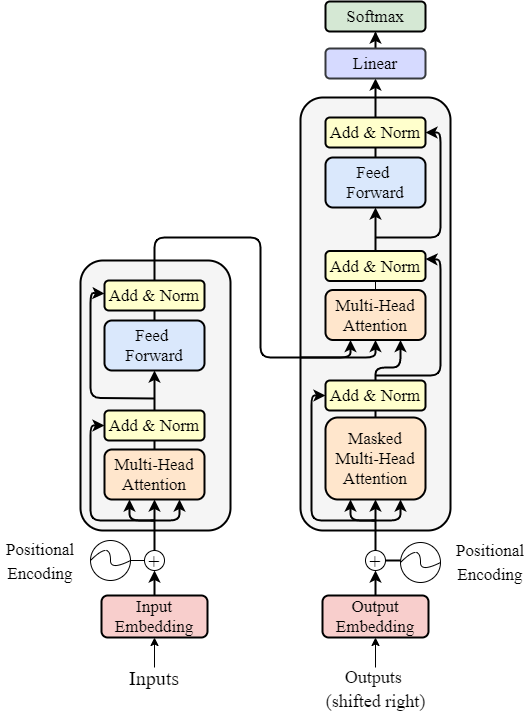

In [7]:
a = torch.randn(3,4,5,6)

In [8]:
a.transpose(2,3).size()

torch.Size([3, 4, 6, 5])

In [9]:
a.transpose(-1,-2).size()

torch.Size([3, 4, 6, 5])